### **Set-up**

In [13]:
#!pip install ydata-profiling
#!pip install pyjanitor --quiet
#!pip install folium
#!pip install mapclassify

In [6]:
import pandas as pd

# Display all columns without truncation
pd.set_option('display.max_columns', None)


## **Read in the provided Excel file**

In [7]:
# reading in the provided Excel file
path = 'data/service-requests-oct-to-dec-2023.xlsx'
df = pd.read_excel(
    path,
    sheet_name='Waste Service Requests'
    )
# rename columns to make them easier to work with
df = df.rename(
    columns={
        'Refuse Service': 'refuse_service',
        'Service Request received': 'service_request_recd',
        'Unique Route number': 'unique_route_number',
        'Ward': 'ward',
        'Locality': 'locality',
        'Day': 'day'
        }
    )
df = df[df['refuse_service']=='Residual']
df = df.reset_index()

In [8]:
# @title
df.shape

(1327, 7)

### **Ensure the data is clean and well structured**

In [9]:
# Check if any ward is associated with more than one locality
ward_locality_check = df.groupby('ward')['locality'].nunique()

wards_with_multiple_localities = ward_locality_check[ward_locality_check > 1]

if not wards_with_multiple_localities.empty:
    print("Wards associated with more than one locality:")
    print(wards_with_multiple_localities)
else:
    print("All wards are associated with only one locality.")

All wards are associated with only one locality.


In [10]:
# when plotting and working with the data, I noticed that
# one entry has '17-Portobello/Craigmillar' as belonging to the South East
# locality where it should be in the North East - correcting this data

# # Update the 'locality' column with the new value ('North East') for the specified conditions
# df.loc[(df.ward == '17-Portobello/Craigmillar') & (df.locality == 'South East'), 'locality'] = 'North East'

# #checking that it is no longer showing in South East
# df[(df.ward=='17-Portobello/Craigmillar') & (df.locality=='South East')]

### **Initial look**

In [11]:
df.isnull().any()

index                   False
refuse_service          False
service_request_recd    False
unique_route_number     False
ward                    False
locality                False
day                     False
dtype: bool

The most common date is 28th December followed by 27th December, 8th and 6th November
Could this be that there was extra volume of waste following Christmas and trucks reached capacity?
Or due to staff holidays collections did not happen on scheduled date?

In [12]:
df.service_request_recd.value_counts()

service_request_recd
2023-12-28    58
2023-12-27    40
2023-11-08    38
2023-11-06    34
2023-11-01    31
              ..
2023-10-01     2
2023-12-24     1
2023-11-12     1
2023-12-03     1
2023-12-25     1
Name: count, Length: 91, dtype: int64

In [13]:
df.refuse_service.value_counts()

refuse_service
Residual    1327
Name: count, dtype: int64

In [14]:
df.groupby(['ward', 'refuse_service']).size()

ward                            refuse_service
01-Almond                       Residual          111
02-Pentland Hills               Residual           33
03-Drum Brae/Gyle               Residual           40
04-Forth                        Residual          197
05-Inverleith                   Residual           63
06-Corstorphine/Murrayfield     Residual           29
07-Sighthill/Gorgie             Residual           46
08-Colinton/Fairmilehead        Residual           79
09-Fountainbridge/Craiglockhar  Residual           46
10-Meadows/Morningside          Residual           49
11-City Centre                  Residual           26
12-Leith Walk                   Residual           11
13-Leith                        Residual           51
14-Craigentinny/Duddingston     Residual          101
15-Southside/Newington          Residual           61
16-Liberton/Gilmerton           Residual          185
17-Portobello/Craigmillar       Residual          199
dtype: int64

In [16]:
df.service_request_recd.min()

Timestamp('2023-10-01 00:00:00')

In [15]:
df.service_request_recd.max()

Timestamp('2023-12-31 00:00:00')

<Axes: title={'center': 'Overall Service Request Type Frequency'}, xlabel='refuse_service'>

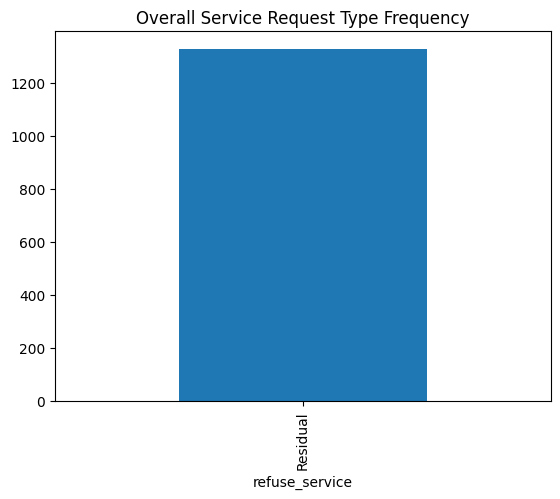

In [17]:
df.refuse_service.value_counts().plot(kind = 'bar', title = 'Overall Service Request Type Frequency')

<Axes: title={'center': 'Service Request Frequency by Locality'}, xlabel='locality'>

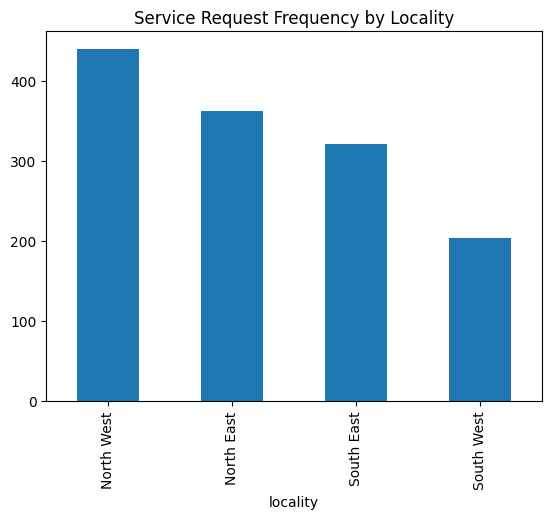

In [18]:
df.locality.value_counts().plot(kind = 'bar', title = 'Service Request Frequency by Locality')

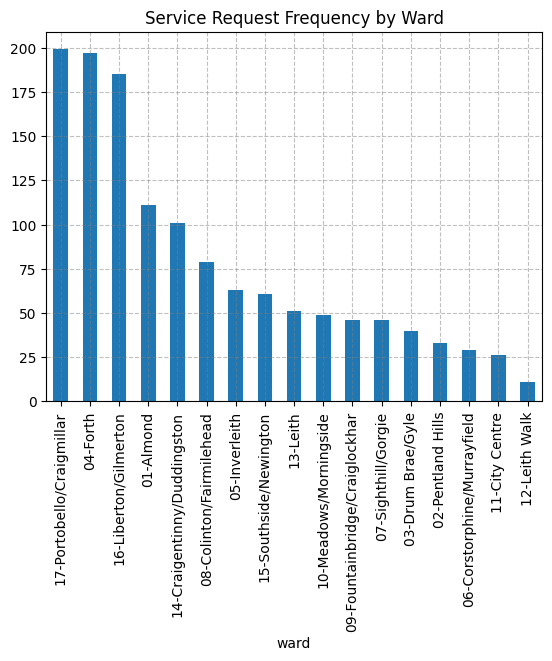

In [19]:
import matplotlib.pyplot as plt

ax = df.ward.value_counts().plot(kind = 'bar', title = 'Service Request Frequency by Ward')
ax.grid(True, linestyle='--', which='both', color='gray', alpha=0.5)
plt.show()

In [60]:
pd.crosstab(df['refuse_service'], df['day'])

day             Fri  Thu  Tue  Wed
refuse_service                    
Residual        375  269  413  270

## **Initial plots - covering all refuse services**

### **Service requests by Locality**

In [20]:
cross_tab_locality = pd.crosstab(df['service_request_recd'], df['locality'])
cross_tab_locality

locality              North East  North West  South East  South West
service_request_recd                                                
2023-10-01                     0           1           0           1
2023-10-02                     3           2           1           0
2023-10-03                     2           5           2           2
2023-10-04                     9           4           2           5
2023-10-05                    11           5           4           7
...                          ...         ...         ...         ...
2023-12-27                     4          21           6           9
2023-12-28                     3          26          14          15
2023-12-29                     2           8           8           4
2023-12-30                     1           3           8           4
2023-12-31                     0           1           4           0

[91 rows x 4 columns]

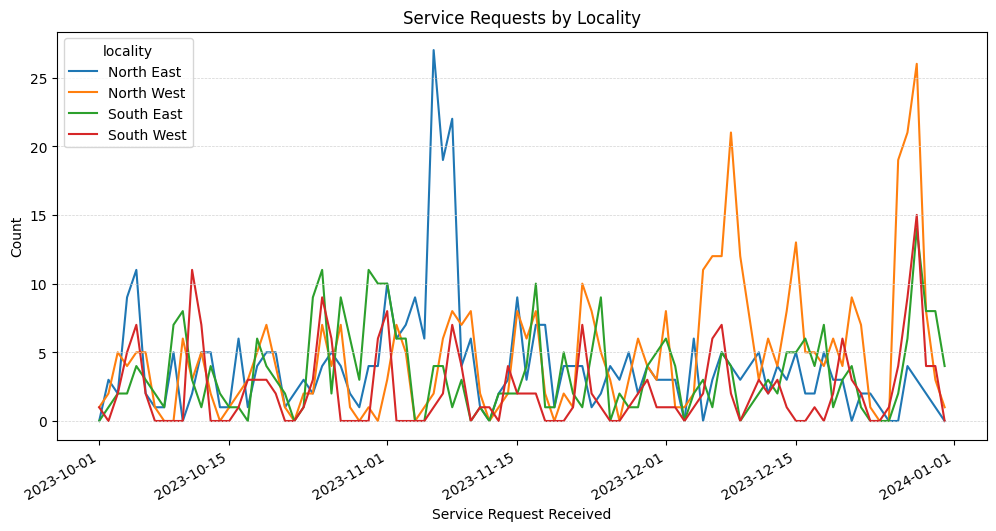

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the cross tab
cross_tab_locality = pd.crosstab(df['service_request_recd'], df['locality'])

# Now you can plot the time series for each locality
ax = cross_tab_locality.plot(kind='line', figsize=(12, 6))

# Title and axis labels
ax.set_title('Service Requests by Locality')
ax.set_xlabel('Service Request Received')
ax.set_ylabel('Count')

# Add horizontal lines for readability
for y in range(0, cross_tab_locality.max().max() + 1, 5):
    ax.axhline(y=y, color='lightgray', linestyle='--', linewidth=0.5)

plt.show()

### **Cumulative sum of service requests by locality**
Might be easier to compare localities using cumlative sum.

<Figure size 640x480 with 0 Axes>

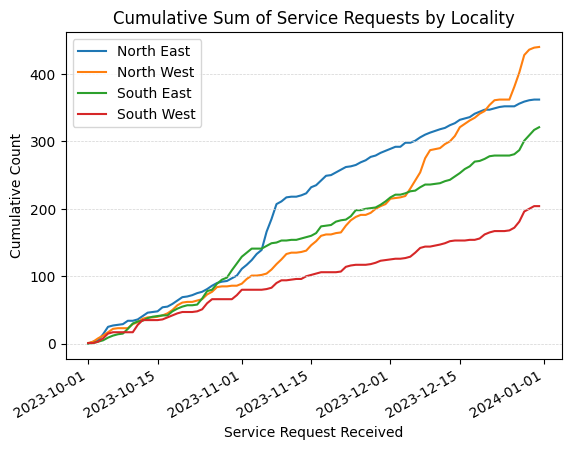

In [23]:
# Cumulative sum of the cross tab
cross_tab_locality_cumulative = cross_tab_locality.cumsum()

# Plotting
plt.figure()
ax = cross_tab_locality_cumulative.plot()

# Title and axis labels
plt.title('Cumulative Sum of Service Requests by Locality')
plt.xlabel('Service Request Received')
plt.ylabel('Cumulative Count')

# Add horizontal lines for readability
y_max = cross_tab_locality_cumulative.values.max()
for y in range(0, int(y_max) + 1, 100):
    ax.axhline(y=y, color='lightgray', linestyle='--', linewidth=0.5)

plt.legend(loc='best')
plt.show()

### **Faceting by Locality**

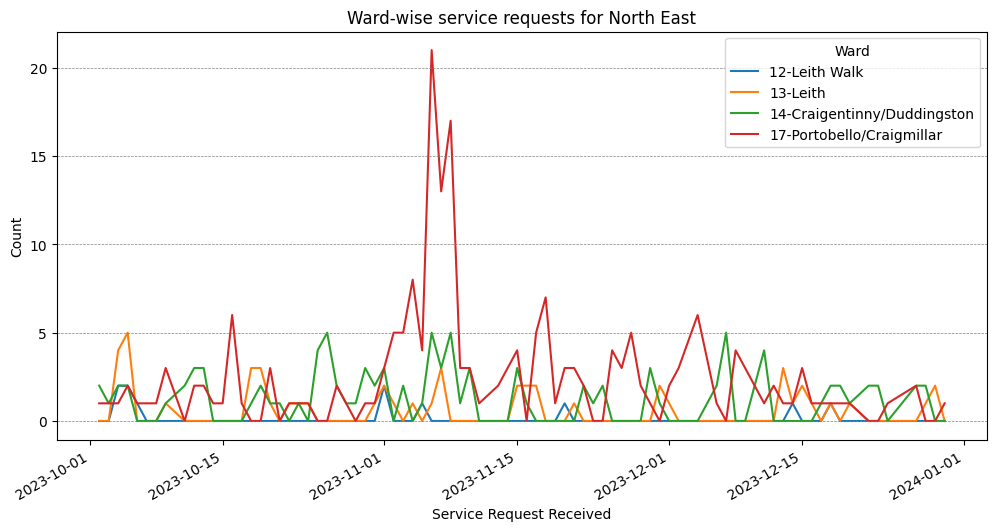

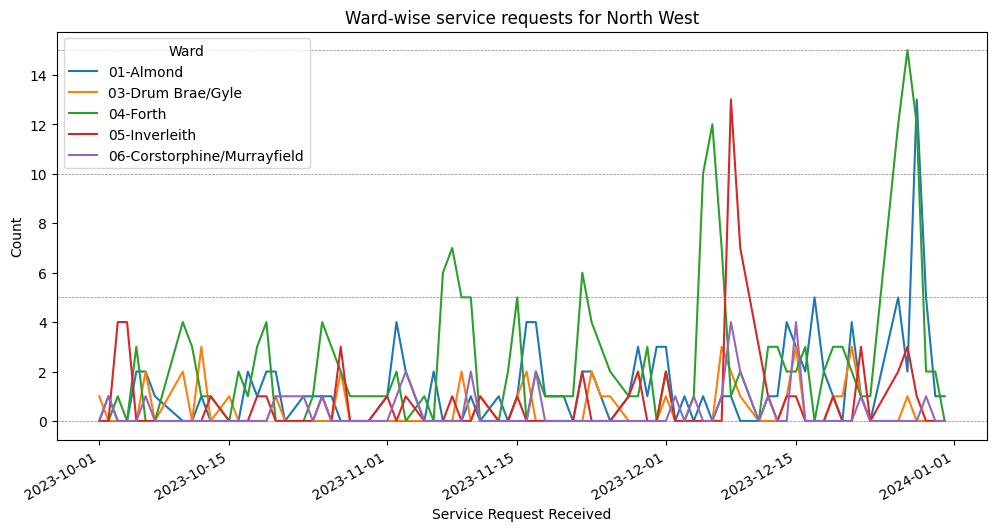

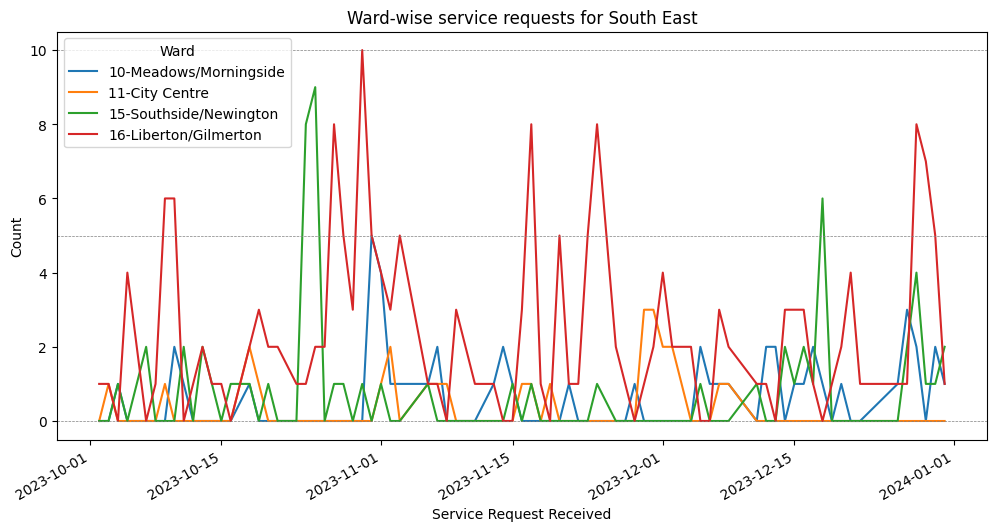

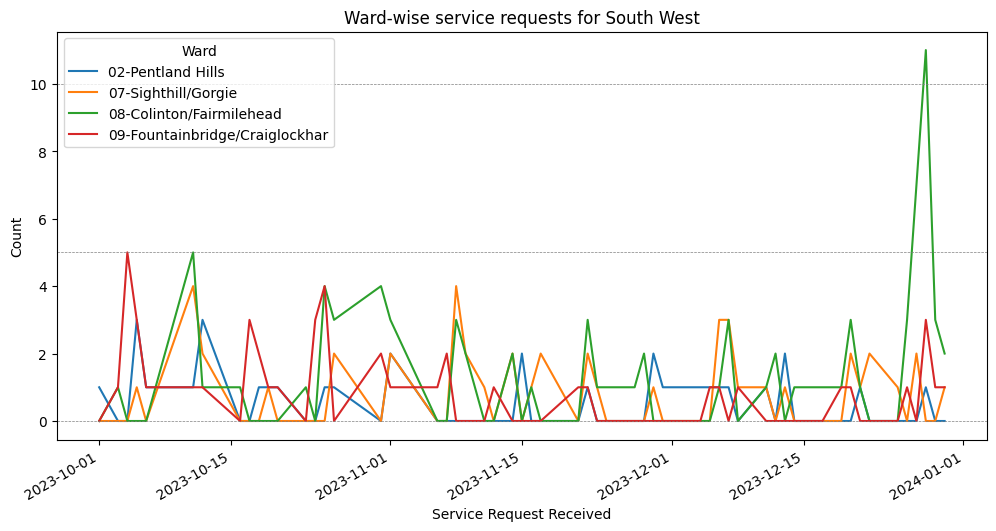

In [22]:
import matplotlib.pyplot as plt

# Group by locality and create a separate plot for each group
for locality, group in df.groupby('locality'):
    cross_tab_ward = pd.crosstab(group['service_request_recd'], group['ward'])
    ax = cross_tab_ward.plot(kind='line', figsize=(12, 6))
    ax.set_title(f'Ward-wise service requests for {locality}')
    ax.set_xlabel('Service Request Received')
    ax.set_ylabel('Count')
    ax.legend(title='Ward')

    # Add horizontal lines for better readability
    for value in range(0, cross_tab_ward.max().max() + 1, 5):
        ax.axhline(y=value, color='gray', linestyle='--', linewidth=0.5)

    plt.show()

### **Faceting Locality by cumulative sum**

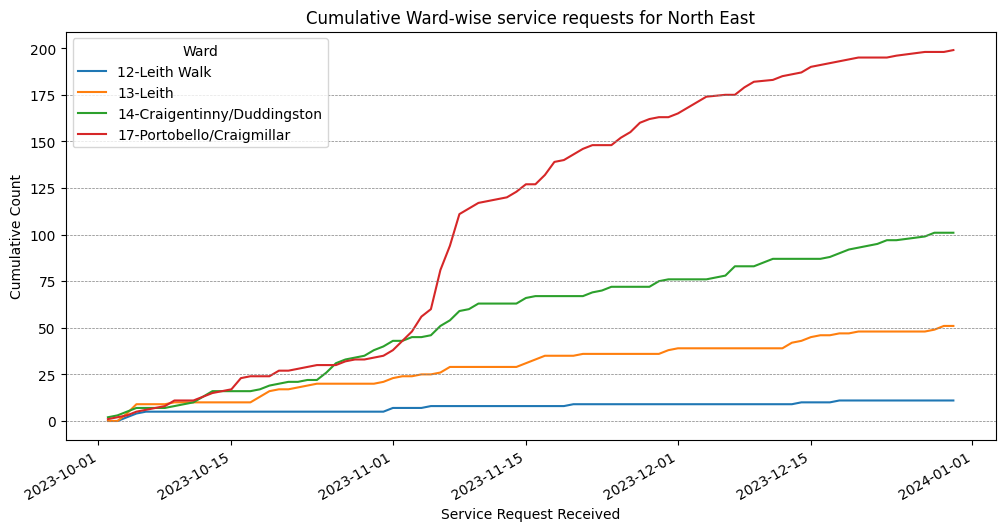

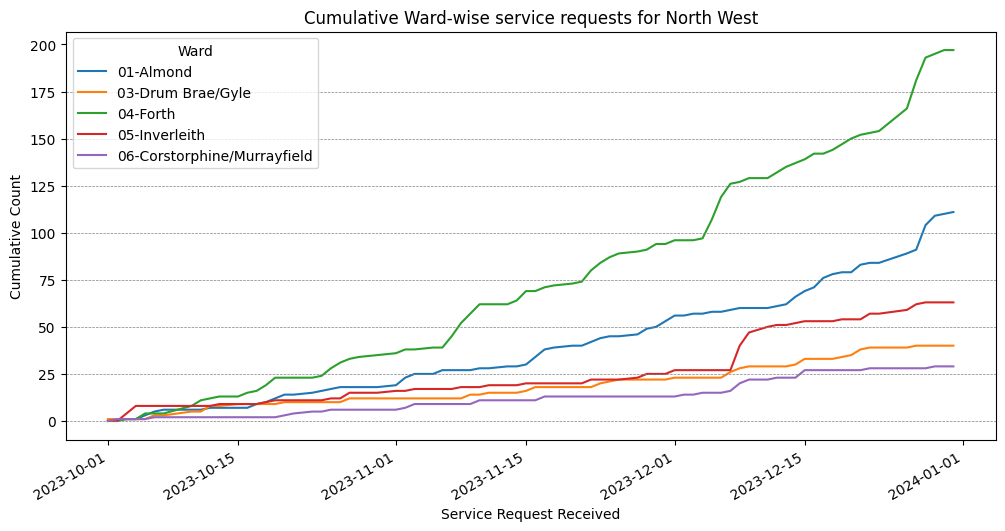

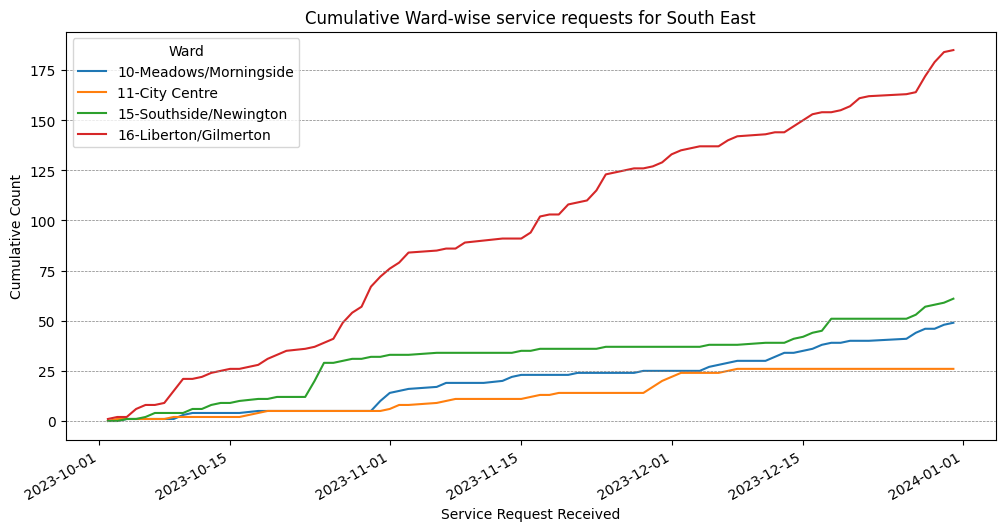

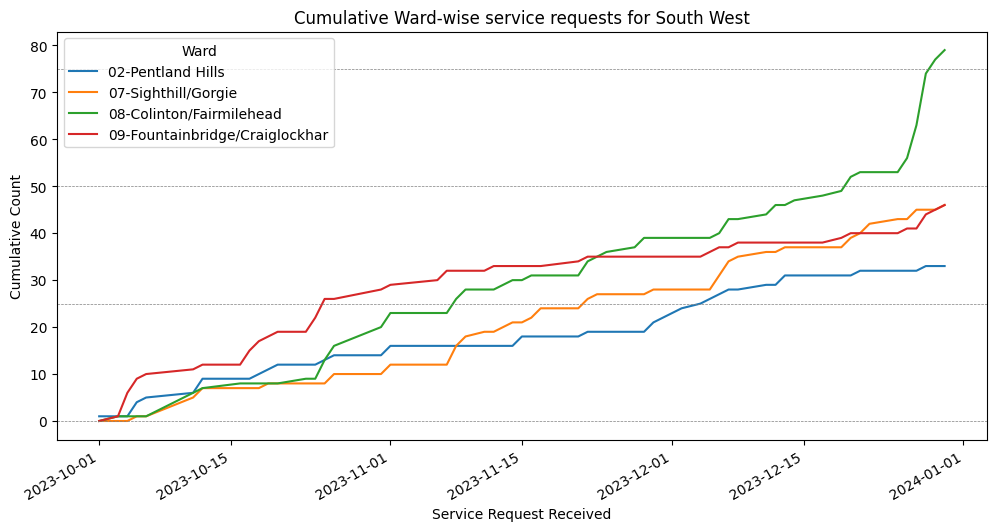

In [24]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# Replace df with the name of your DataFrame if different

# Group by locality and create a separate plot for each group
for locality, group in df.groupby('locality'):
    cross_tab_ward_cumulative = pd.crosstab(group['service_request_recd'], group['ward'])
    cumsum_cross_tab = cross_tab_ward_cumulative.cumsum()  # Compute cumulative sum

    ax = cumsum_cross_tab.plot(kind='line', figsize=(12, 6))
    ax.set_title(f'Cumulative Ward-wise service requests for {locality}')
    ax.set_xlabel('Service Request Received')
    ax.set_ylabel('Cumulative Count')
    ax.legend(title='Ward')

    # Add horizontal lines for better readability
    for value in range(0, cumsum_cross_tab.max().max() + 1, 25):  # Adjust step size as needed
        ax.axhline(y=value, color='gray', linestyle='--', linewidth=0.5)

    plt.show()

In [25]:
# Group by 'locality' and count unique 'unique_route_number'
unique_route_counts = df.groupby('locality')['unique_route_number'].nunique()

print(unique_route_counts)

locality
North East    22
North West    34
South East    29
South West    28
Name: unique_route_number, dtype: int64


In [30]:
# Group
unique_route_counts_per_ward = df.groupby('ward')['unique_route_number'].nunique().reset_index().sort_values(by='unique_route_number', ascending=False)

print(unique_route_counts_per_ward)

                              ward  unique_route_number
0                        01-Almond                   17
15           16-Liberton/Gilmerton                   15
3                         04-Forth                   11
13     14-Craigentinny/Duddingston                   10
8   09-Fountainbridge/Craiglockhar                   10
16       17-Portobello/Craigmillar                   10
7         08-Colinton/Fairmilehead                    9
14          15-Southside/Newington                    9
2                03-Drum Brae/Gyle                    9
6              07-Sighthill/Gorgie                    8
9           10-Meadows/Morningside                    8
5      06-Corstorphine/Murrayfield                    7
1                02-Pentland Hills                    7
4                    05-Inverleith                    7
10                  11-City Centre                    6
11                   12-Leith Walk                    4
12                        13-Leith              

### **Faceting by route number**

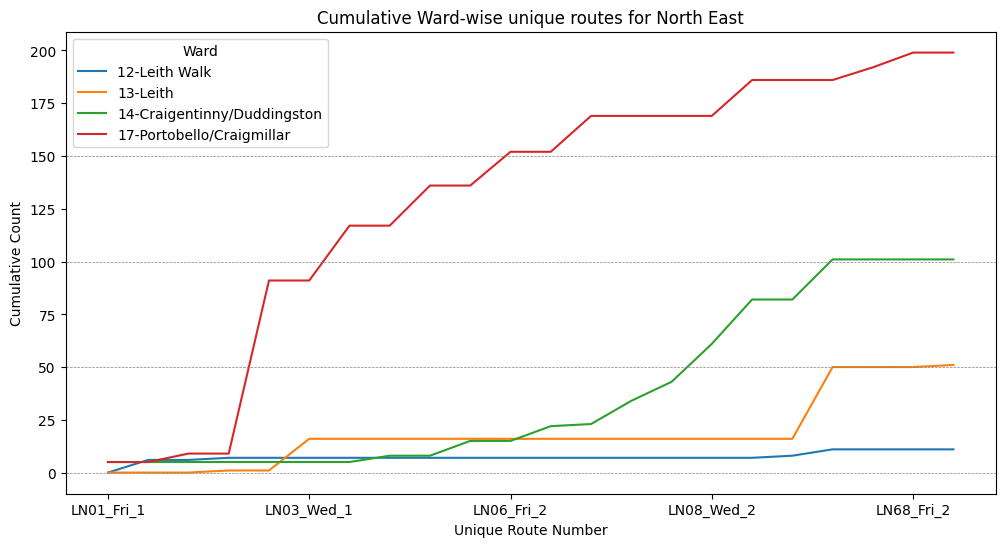

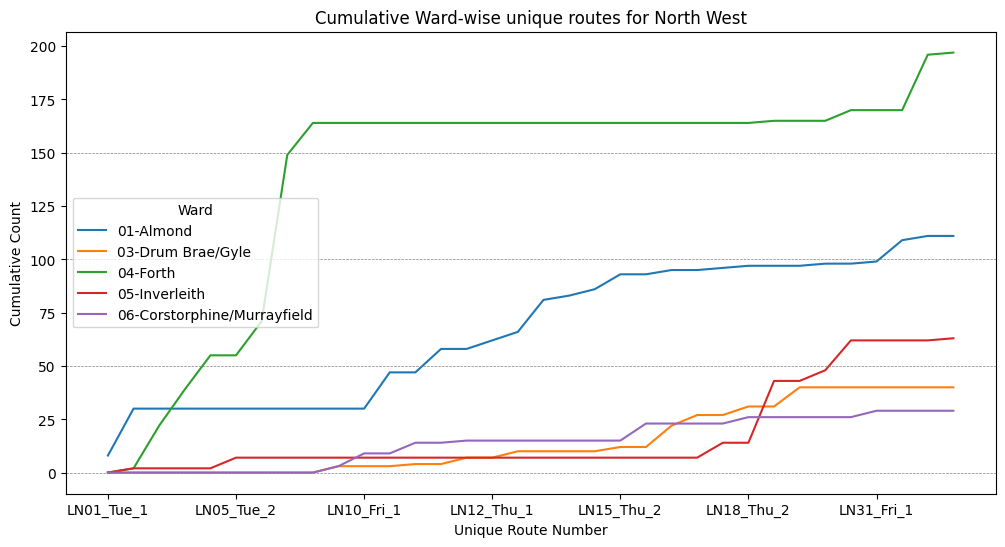

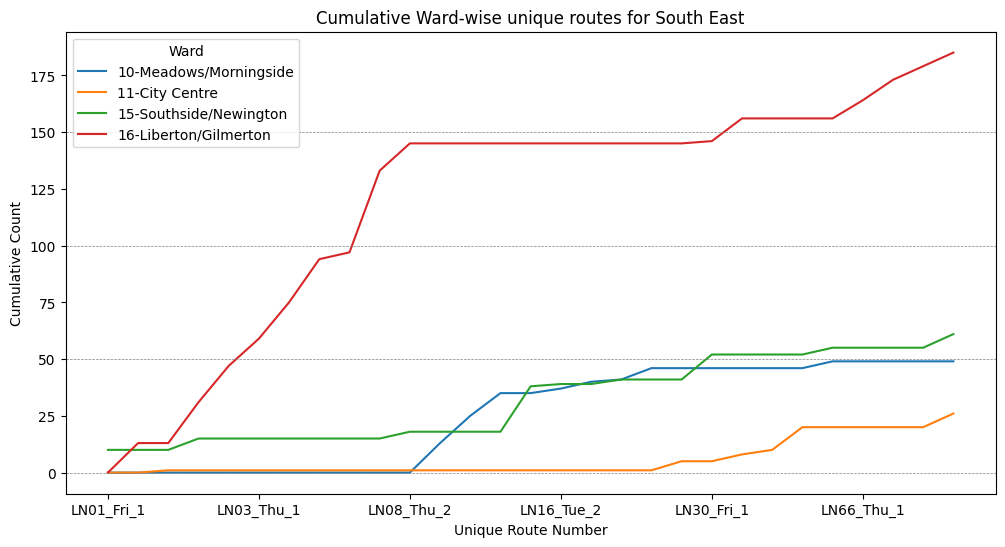

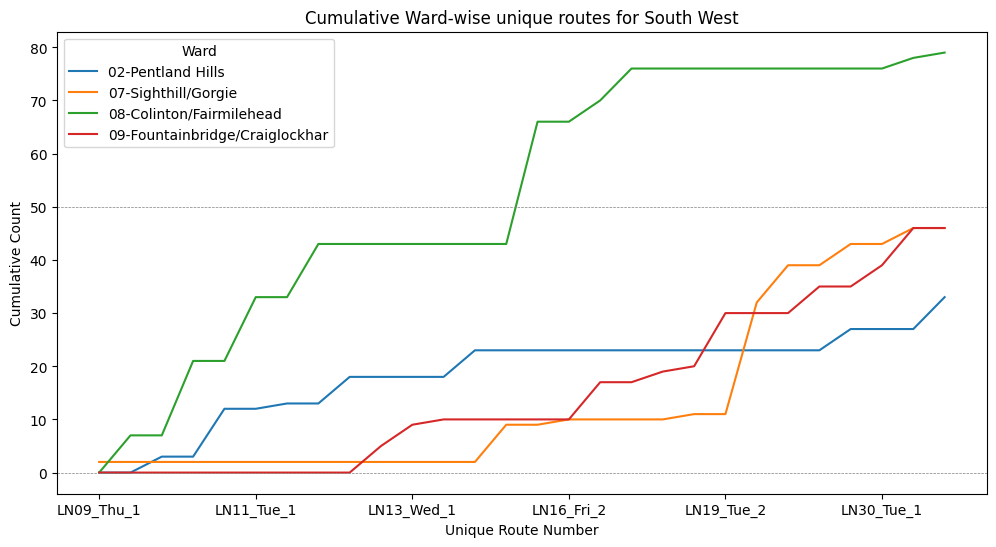

In [32]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# Replace df with the name of your DataFrame if different

# Group by locality and create a separate plot for each group
for locality, group in df.groupby('locality'):
    cross_tab_ward_route = pd.crosstab(group['unique_route_number'], group['ward'])
    cumsum_cross_tab_route = cross_tab_ward_route.cumsum()  # Compute cumulative sum

    ax = cumsum_cross_tab_route.plot(kind='line', figsize=(12, 6))
    ax.set_title(f'Cumulative Ward-wise unique routes for {locality}')
    ax.set_xlabel('Unique Route Number')
    ax.set_ylabel('Cumulative Count')
    ax.legend(title='Ward')

    # Add horizontal lines for better readability
    for value in range(0, cumsum_cross_tab_route.max().max() + 1, 50):  # Adjust step size as needed
        ax.axhline(y=value, color='gray', linestyle='--', linewidth=0.5)

    plt.show()


## **What other data might be useful?**
Each Ward will have a different proportions of Communal and Kerbside waste collection because of differences in housing stock in different areas of the city. It would be useful to have that information to help benchmark each Ward more fairly. We could also use that information on a Locality basis too.

- An indication of the boundary of each Ward might also be useful to have available (source: https://data.edinburghcouncilmaps.info/datasets/dc96624b1db849db926f59806e287d44/explore)
- An indication of how many househounds in each Ward would receive a wheelie bin collection / blue box / food collection service (source: https://www.edinburgh.gov.uk/downloads/file/24272/ward-profiles)

### **Reading in the GeoJSON file**
- This provides location data for the council wards
- (source: https://data.edinburghcouncilmaps.info/datasets/dc96624b1db849db926f59806e287d44/explore)

In [26]:
# @title
import geopandas as gpd

# Reading in the GeoJSON file containing Ward boundaries
geojson_path = 'data/Edinburgh_Ward_Boundaries.geojson'
wards_gdf = gpd.read_file(geojson_path)

# rename columns
wards_gdf = wards_gdf.rename(
    columns={
        'OBJECTID': 'objectid',
        'Ward_Name': 'ward_name',
        'Link': 'link',
        'Ward_No': 'ward_no',
        'Date': 'date',
        'Ward_Code': 'ward_code'
        }
    )
# show the data
wards_gdf.head(1)


objectid ward_name                                               link  \
0         1    Almond  https://democracy.edinburgh.gov.uk/mgMemberInd...   

                                              Review  ward_no            date  \
0  Fifth Statutory Review of Electoral Arrangemen...        1  September 2016   

   ward_code                                           geometry  
0  S13002919  MULTIPOLYGON (((-3.34261 56.00385, -3.34243 56...

Joining the two data set together.

In [27]:
# @title
# creating a suitable common field to join the two dataset with

# Extract the numeric part to a new field
df['ward_no'] = df['ward'].str.extract(r'(\d+)')

# Convert the new field to numeric if needed
df['ward_no'] = pd.to_numeric(df['ward_no'])

# joining the service request data from confirm with the geojson map info together
result = pd.merge(
    df,
    wards_gdf[['ward_no', 'ward_code', 'ward_name', 'geometry']],
    left_on = 'ward_no',
    right_on = 'ward_no',
    how = 'left',
    indicator = True
)

# show the result
result.head(1)

index refuse_service service_request_recd unique_route_number  \
0   2349       Residual           2023-10-12          LN68_Thu_2   

                    ward    locality  day  ward_no  ward_code  \
0  16-Liberton/Gilmerton  South East  Thu       16  S13002934   

              ward_name                                           geometry  \
0  Liberton / Gilmerton  POLYGON ((-3.15208 55.92488, -3.15215 55.92494...   

  _merge  
0   both

In [28]:
# checking everything joined ok
result._merge.value_counts()

_merge
both          1327
left_only        0
right_only       0
Name: count, dtype: int64

In [29]:
# removing the indicator field
result = result.drop(['_merge',], axis=1)

# saving the result as a geo data frame
gdf = gpd.GeoDataFrame(result, geometry='geometry')

# checking the type
print("Using type():", type(gdf))

Using type(): <class 'geopandas.geodataframe.GeoDataFrame'>


### **Grouping together by Ward and Locality**

In [30]:
# @title
ward_gdf = gdf.groupby(
    ['ward_no',
     'ward',
     'locality',
     'geometry'
     ]).agg(
        {'unique_route_number': 'count'}).reset_index().sort_values(
            by='ward', ascending=True)
ward_gdf  = gpd.GeoDataFrame(ward_gdf , geometry='geometry')
ward_gdf

ward_no                            ward    locality  \
0         1                       01-Almond  North West   
1         2               02-Pentland Hills  South West   
2         3               03-Drum Brae/Gyle  North West   
3         4                        04-Forth  North West   
4         5                   05-Inverleith  North West   
5         6     06-Corstorphine/Murrayfield  North West   
6         7             07-Sighthill/Gorgie  South West   
7         8        08-Colinton/Fairmilehead  South West   
8         9  09-Fountainbridge/Craiglockhar  South West   
9        10          10-Meadows/Morningside  South East   
10       11                  11-City Centre  South East   
11       12                   12-Leith Walk  North East   
12       13                        13-Leith  North East   
13       14     14-Craigentinny/Duddingston  North East   
14       15          15-Southside/Newington  South East   
15       16           16-Liberton/Gilmerton  South East   
16       17       17-Portobello/Craigmillar  North East   

                                             geometry  unique_route_number  
0   MULTIPOLYGON (((-3.34261 56.00385, -3.34243 56...                  111  
1   POLYGON ((-3.34951 55.92681, -3.34952 55.92681...                   33  
2   POLYGON ((-3.31947 55.94284, -3.32000 55.94282...                   40  
3   POLYGON ((-3.21741 55.98578, -3.21741 55.98600...                  197  
4   POLYGON ((-3.19458 55.97134, -3.19462 55.97137...                   63  
5   POLYGON ((-3.24757 55.95663, -3.24763 55.95663...                   29  
6   POLYGON ((-3.21695 55.94556, -3.21697 55.94553...                   46  
7   POLYGON ((-3.23438 55.91571, -3.23438 55.91574...                   79  
8   POLYGON ((-3.20991 55.94461, -3.20995 55.94467...                   46  
9   POLYGON ((-3.22095 55.91170, -3.22085 55.91168...                   49  
10  POLYGON ((-3.20081 55.94107, -3.20064 55.94106...                   26  
11  POLYGON ((-3.17964 55.97295, -3.17971 55.97302...                   11  
12  POLYGON ((-3.16878 55.96774, -3.16849 55.96799...                   51  
13  POLYGON ((-3.13104 55.96819, -3.13159 55.96850...                  101  
14  POLYGON ((-3.19029 55.91959, -3.19022 55.91959...                   61  
15  POLYGON ((-3.15208 55.92488, -3.15215 55.92494...                  185  
16  POLYGON ((-3.11266 55.95836, -3.11318 55.95837...                  199

### **Creating the Locality geometry**
Because we have the ward boundaries, we can use this info to dissolve these areas into Locality boundaries.

In [31]:
# @title
locality_gdf = gdf.groupby(
    ['ward_no',
     'ward',
     'locality',
     'geometry'
     ]).agg(
        {'unique_route_number': 'count'}).reset_index().sort_values(
            by='locality', ascending=True)
locality_gdf  = gpd.GeoDataFrame(locality_gdf , geometry='geometry')

# disolving the poloygons to give us the larger locality geometries
locality_counts = locality_gdf[['locality', 'geometry', 'unique_route_number']]
localities = locality_counts.dissolve(by='locality', aggfunc='sum')
localities = localities.reset_index()
localities
print("Using type():", type(localities))

Using type(): <class 'geopandas.geodataframe.GeoDataFrame'>


In [39]:
localities

locality                                           geometry  \
0  North East  POLYGON ((-3.11530 55.95970, -3.11508 55.95965...   
1  North West  MULTIPOLYGON (((-3.23055 55.94962, -3.23084 55...   
2  South East  POLYGON ((-3.14844 55.92245, -3.14812 55.92222...   
3  South West  POLYGON ((-3.27080 55.87410, -3.27116 55.87377...   

   unique_route_number  
0                  362  
1                  440  
2                  321  
3                  204

In [32]:
localities.unique_route_number.sum()

1327

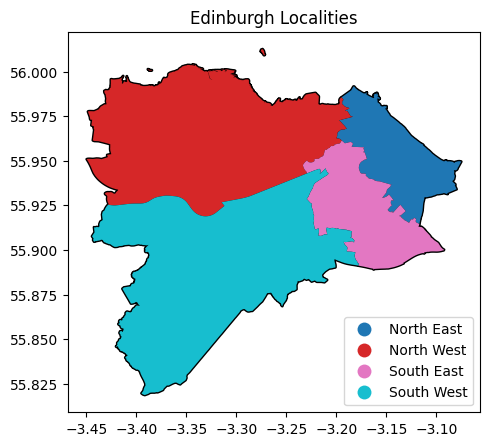

In [34]:
# @title
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the GeoDataFrame
localities.plot(ax=ax, column='locality', edgecolor='black', linewidth=2, legend=False)

# Add legend to a separate axis
localities.plot(ax=ax, column='locality', legend=True, legend_kwds={'loc': 'lower right'})

# Add a title to the plot
plt.title('Edinburgh Localities')

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

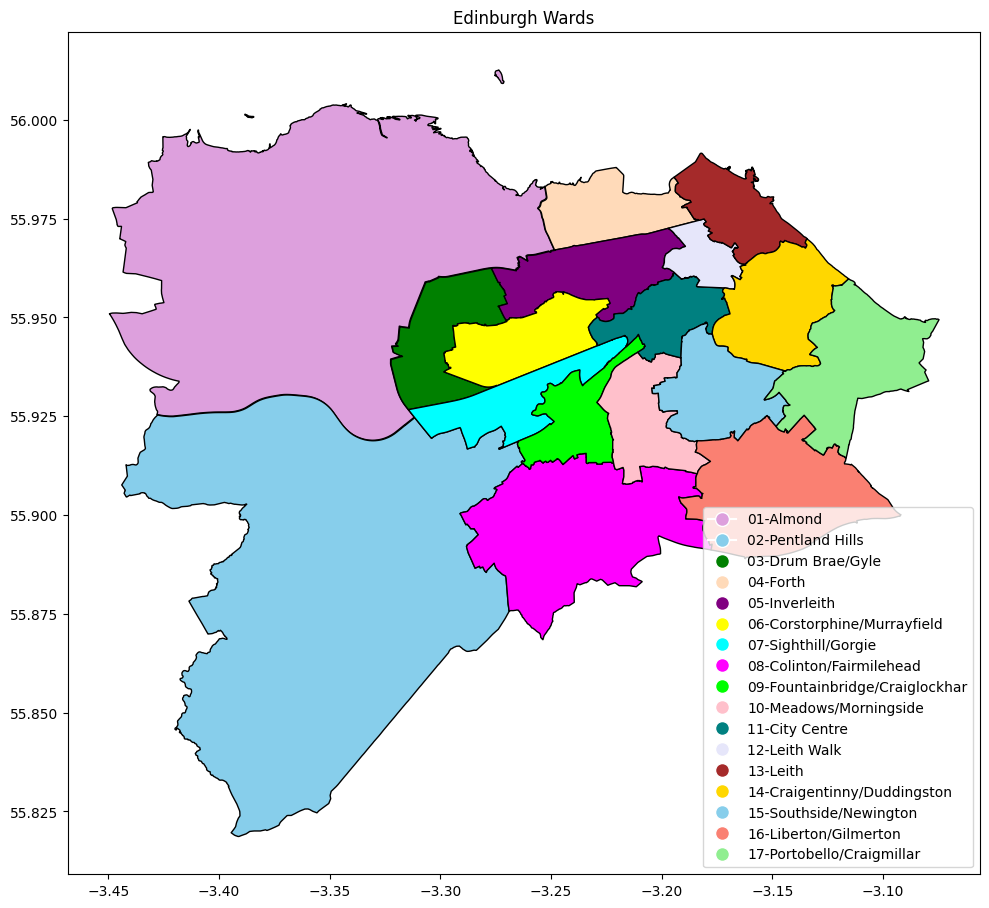

In [36]:
# @title
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.lines import Line2D

group_gdf = gdf.groupby(
    ['ward',
     'geometry'
     ]).agg(
        {'unique_route_number': 'count'}).reset_index().sort_values(
            by='ward', ascending=True)
group_gdf = gpd.GeoDataFrame(group_gdf, geometry='geometry')

# Assuming 'gdf' is your GeoDataFrame containing ward information

# Get unique wards
wards = group_gdf['ward'].unique()

# Define a list of distinct colors
colors = ['plum', 'skyblue', 'green', 'peachpuff', 'purple', 'yellow', 'cyan', 'magenta', 'lime', 'pink', 'teal', 'lavender', 'brown', 'gold', 'skyblue', 'salmon', 'lightgreen']
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with lines around the wards using the ward_color column
for i, ward in enumerate(wards):
    group_gdf[group_gdf['ward'] == ward].plot(ax=ax, color=colors[i % len(colors)], edgecolor='black', linewidth=1)

# Create custom legend handles
legend_handles = [Line2D([0], [0], marker='o', color='w', label=ward, markerfacecolor=color, markersize=10) for ward, color in zip(wards, colors)]

# Add legend to the plot
ax.legend(handles=legend_handles, loc='lower right')

# Add a title to the plot
plt.title('Edinburgh Wards')

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()


### **Gather info about number of "kerbside collection" households in each Ward**
- I have made the assumption that any households classified as **'Flats/tenement'** or **'Caravan/temporary'** do not have kerbside collection.
- (source: https://www.edinburgh.gov.uk/downloads/file/24272/ward-profiles)
- Reading in a grouping the data:

In [37]:
# @title
path = 'data/ward-household-spaces.xlsx'
ward_values = pd.read_excel(
    path,
    sheet_name='Sheet1'
    )

import numpy as np

# Create a new column 'collection_type' based on conditions
ward_values['collection_type'] = np.select(
    [
        ward_values['type'].isin(['Flats/tenement', 'Caravan/temporary']),
        ~ward_values['type'].isin(['Flats/tenement', 'Caravan/temporary'])
    ],
    ['Communal', 'Kerbside'],
    default=np.nan  # or any other default value you want
)

# grouping the ward data

# Group by 'ward_no', 'ward', and 'collection_type', then sum the 'no' values
grouped_by_ward_df = ward_values.groupby(['ward_no', 'ward', 'collection_type'])['no'].sum().reset_index()

# Display the resulting DataFrame of just Kerbside data
ward_kerbside = grouped_by_ward_df[grouped_by_ward_df.collection_type=='Kerbside']

ward_kerbside = ward_kerbside.reset_index(drop=True)

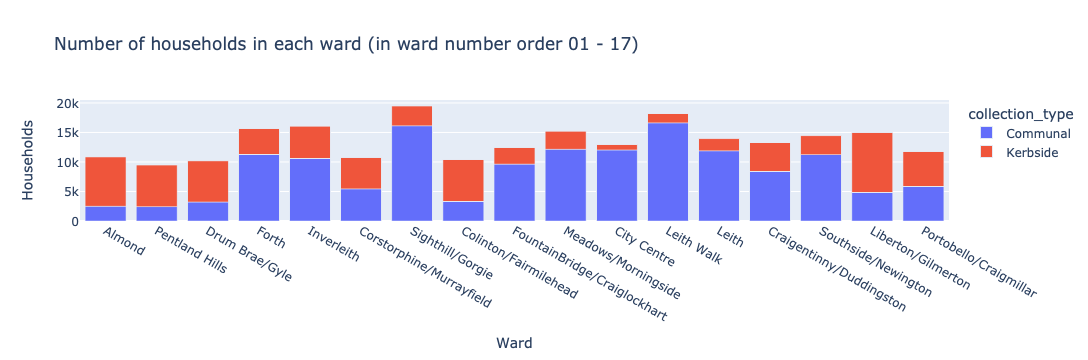

In [38]:
# @title
import plotly.express as px

# Order the DataFrame by total 'no' value
#ordered_df = grouped_by_ward_df.sort_values(by='no', ascending=False)

# Create a bar chart with titles and ordered x-axis
fig = px.bar(
    grouped_by_ward_df,
    x='ward',
    y='no',
    color='collection_type',
    title='Number of households in each ward (in ward number order 01 - 17)',
    labels={'ward': 'Ward', 'no': 'Households'},
    #category_orders={'ward': ordered_df['ward'].tolist()}  # Order by total 'no'
)

# Show the plot
fig.show()

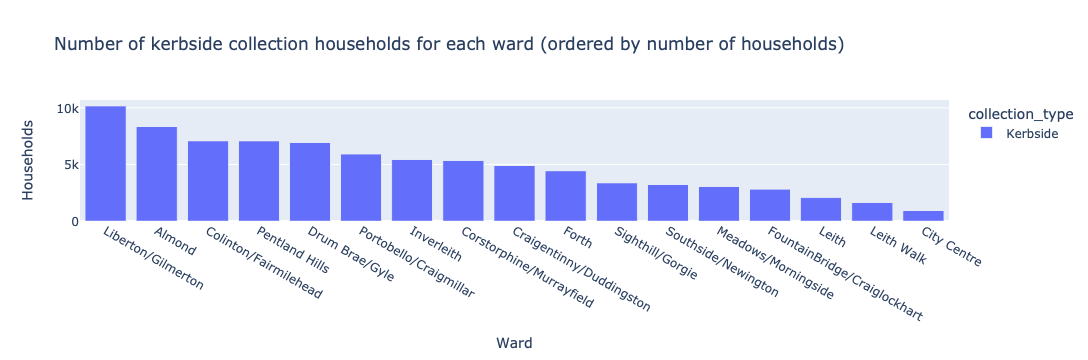

In [39]:
# @title
import plotly.express as px

sorted_ward_list = ward_kerbside.sort_values(by='no', ascending=False)['ward'].tolist()

# Create a bar chart
fig = px.bar(
    #grouped_by_ward_df[grouped_by_ward_df.collection_type=="Kerbside"],
    ward_kerbside,
    x='ward',
    y='no',
    color='collection_type',
    title='Number of kerbside collection households for each ward (ordered by number of households)',
    labels={
        'ward': 'Ward',
        'no': 'Households'},
    category_orders={'ward': sorted_ward_list})  # Order by total 'no'

# Show the plot
fig.show()

In [41]:
# sorted in descending orderby number of Kerbside collection households
ward_kerbside = ward_kerbside.sort_values(by='no', ascending=False)
ward_kerbside

ward_no                          ward collection_type     no
15       16            Liberton/Gilmerton        Kerbside  10160
0         1                        Almond        Kerbside   8331
7         8         Colinton/Fairmilehead        Kerbside   7071
1         2                Pentland Hills        Kerbside   7068
2         3                Drum Brae/Gyle        Kerbside   6957
16       17        Portobello/Craigmillar        Kerbside   5912
4         5                    Inverleith        Kerbside   5450
5         6      Corstorphine/Murrayfield        Kerbside   5347
13       14      Craigentinny/Duddingston        Kerbside   4884
3         4                         Forth        Kerbside   4423
6         7              Sighthill/Gorgie        Kerbside   3357
14       15           Southside/Newington        Kerbside   3208
9        10           Meadows/Morningside        Kerbside   3035
8         9  FountainBridge/Craiglockhart        Kerbside   2807
12       13                         Leith        Kerbside   2050
11       12                    Leith Walk        Kerbside   1628
10       11                   City Centre        Kerbside    948

In [42]:
# creating a high level grouping of the service request data
high_level_grp = gdf.groupby(
    ['ward_no', 'ward_name']
    ).size().reset_index(name='count_of_rows').sort_values(by='count_of_rows', ascending=False)

In [43]:
# joining together kerbside households data with the service request data
ward_kerbside = pd.merge(
    ward_kerbside,
    high_level_grp[['ward_no', 'count_of_rows']],
    on='ward_no',
    how='left',
    #indicator=True
)

In [44]:
# rename columns
ward_kerbside = ward_kerbside.rename(
    columns={
        'no': 'number_of_households',
        'count_of_rows': 'number_of_service_requests'
        })

In [45]:
#service_requests_per_household
ward_kerbside['service_requests_per_household'] = (ward_kerbside['number_of_service_requests'] / ward_kerbside['number_of_households'])

#percentage of service_requests_per_household
ward_kerbside['percentage_of_service_requests_per_household'] = (ward_kerbside['number_of_service_requests'] / ward_kerbside['number_of_households']) * 100

In [46]:
ward_kerbside.head(1)

ward_no                ward collection_type  number_of_households  \
0       16  Liberton/Gilmerton        Kerbside                 10160   

   number_of_service_requests  service_requests_per_household  \
0                         185                        0.018209   

   percentage_of_service_requests_per_household  
0                                      1.820866

In [47]:
ward_kerbside['number_of_households'].mean()


4860.941176470588

In [48]:
ward_kerbside['number_of_households'].sum()

82636

In [49]:
ward_kerbside['number_of_service_requests'].sum()

1327

In [50]:
max_households = ward_kerbside['number_of_households'].max()
min_households = ward_kerbside['number_of_households'].min()
max_service_requests = ward_kerbside['number_of_service_requests'].max()
min_service_requests = ward_kerbside['number_of_service_requests'].min()
avg_service_requests = ((ward_kerbside['number_of_service_requests'] / ward_kerbside['number_of_households']) * 100).mean()
print("\nMax households:\n{}".format(max_households))
print("\nMin households:\n{}".format(min_households))
print("\nMax service requests:\n{}".format(max_service_requests))
print("\nMin service requests:\n{}".format(min_service_requests))
print("\nAverage service requests:\n{}".format(avg_service_requests))


Max households:
10160

Min households:
948

Max service requests:
199

Min service requests:
11

Average service requests:
1.7252811822477203


In [51]:
top_ten_sr_wards = ward_kerbside.nlargest(10, 'number_of_service_requests')
top_ten_sr_wards

ward_no                      ward collection_type  number_of_households  \
5        17    Portobello/Craigmillar        Kerbside                  5912   
9         4                     Forth        Kerbside                  4423   
0        16        Liberton/Gilmerton        Kerbside                 10160   
1         1                    Almond        Kerbside                  8331   
8        14  Craigentinny/Duddingston        Kerbside                  4884   
2         8     Colinton/Fairmilehead        Kerbside                  7071   
6         5                Inverleith        Kerbside                  5450   
11       15       Southside/Newington        Kerbside                  3208   
14       13                     Leith        Kerbside                  2050   
12       10       Meadows/Morningside        Kerbside                  3035   

    number_of_service_requests  service_requests_per_household  \
5                          199                        0.033660   
9                          197                        0.044540   
0                          185                        0.018209   
1                          111                        0.013324   
8                          101                        0.020680   
2                           79                        0.011172   
6                           63                        0.011560   
11                          61                        0.019015   
14                          51                        0.024878   
12                          49                        0.016145   

    percentage_of_service_requests_per_household  
5                                       3.366035  
9                                       4.453991  
0                                       1.820866  
1                                       1.332373  
8                                       2.067977  
2                                       1.117239  
6                                       1.155963  
11                                      1.901496  
14                                      2.487805  
12                                      1.614498

In [52]:
top_ten_per_sr_per_household = ward_kerbside.nlargest(10, 'percentage_of_service_requests_per_household')
top_ten_per_sr_per_household

ward_no                          ward collection_type  \
9         4                         Forth        Kerbside   
5        17        Portobello/Craigmillar        Kerbside   
16       11                   City Centre        Kerbside   
14       13                         Leith        Kerbside   
8        14      Craigentinny/Duddingston        Kerbside   
11       15           Southside/Newington        Kerbside   
0        16            Liberton/Gilmerton        Kerbside   
13        9  FountainBridge/Craiglockhart        Kerbside   
12       10           Meadows/Morningside        Kerbside   
10        7              Sighthill/Gorgie        Kerbside   

    number_of_households  number_of_service_requests  \
9                   4423                         197   
5                   5912                         199   
16                   948                          26   
14                  2050                          51   
8                   4884                         101   
11                  3208                          61   
0                  10160                         185   
13                  2807                          46   
12                  3035                          49   
10                  3357                          46   

    service_requests_per_household  \
9                         0.044540   
5                         0.033660   
16                        0.027426   
14                        0.024878   
8                         0.020680   
11                        0.019015   
0                         0.018209   
13                        0.016388   
12                        0.016145   
10                        0.013703   

    percentage_of_service_requests_per_household  
9                                       4.453991  
5                                       3.366035  
16                                      2.742616  
14                                      2.487805  
8                                       2.067977  
11                                      1.901496  
0                                       1.820866  
13                                      1.638760  
12                                      1.614498  
10                                      1.370271

### **Taking into account the number of households in each Ward**

The **Forth** ward has the highest percentage (4.45%) of service requests per household across Residual Refuse Services in the dataset. The remainder of the top five are:

- **Portobello/Craigmillar** at 3.37%
- **City Centre** at 2.74%
- **Leith** at 2.48%
- **Craigentinny/Duddingston** at 2.06%


In [60]:
# @title
ward_ks = ward_kerbside.sort_values(by='percentage_of_service_requests_per_household', ascending=False)
ward_ks

ward_no                          ward collection_type  \
3         4                         Forth        Kerbside   
16       17        Portobello/Craigmillar        Kerbside   
10       11                   City Centre        Kerbside   
12       13                         Leith        Kerbside   
13       14      Craigentinny/Duddingston        Kerbside   
14       15           Southside/Newington        Kerbside   
15       16            Liberton/Gilmerton        Kerbside   
8         9  FountainBridge/Craiglockhart        Kerbside   
9        10           Meadows/Morningside        Kerbside   
6         7              Sighthill/Gorgie        Kerbside   
0         1                        Almond        Kerbside   
4         5                    Inverleith        Kerbside   
7         8         Colinton/Fairmilehead        Kerbside   
11       12                    Leith Walk        Kerbside   
2         3                Drum Brae/Gyle        Kerbside   
5         6      Corstorphine/Murrayfield        Kerbside   
1         2                Pentland Hills        Kerbside   

    number_of_households  number_of_service_requests  \
3                   4423                         197   
16                  5912                         199   
10                   948                          26   
12                  2050                          51   
13                  4884                         101   
14                  3208                          61   
15                 10160                         185   
8                   2807                          46   
9                   3035                          49   
6                   3357                          46   
0                   8331                         111   
4                   5450                          63   
7                   7071                          79   
11                  1628                          11   
2                   6957                          40   
5                   5347                          29   
1                   7068                          33   

    service_requests_per_household  \
3                         0.044540   
16                        0.033660   
10                        0.027426   
12                        0.024878   
13                        0.020680   
14                        0.019015   
15                        0.018209   
8                         0.016388   
9                         0.016145   
6                         0.013703   
0                         0.013324   
4                         0.011560   
7                         0.011172   
11                        0.006757   
2                         0.005750   
5                         0.005424   
1                         0.004669   

    percentage_of_service_requests_per_household  
3                                       4.453991  
16                                      3.366035  
10                                      2.742616  
12                                      2.487805  
13                                      2.067977  
14                                      1.901496  
15                                      1.820866  
8                                       1.638760  
9                                       1.614498  
6                                       1.370271  
0                                       1.332373  
4                                       1.155963  
7                                       1.117239  
11                                      0.675676  
2                                       0.574960  
5                                       0.542360  
1                                       0.466893

In [ ]:
# percentage service request per household
top_ten_wards = ward_kerbside.nlargest(10, 'percentage_of_service_requests_per_household')
top_ten_wards

ward_no                          ward collection_type  \
16       11                   City Centre        Kerbside   
9         4                         Forth        Kerbside   
5        17        Portobello/Craigmillar        Kerbside   
10        7              Sighthill/Gorgie        Kerbside   
8        14      Craigentinny/Duddingston        Kerbside   
14       13                         Leith        Kerbside   
11       15           Southside/Newington        Kerbside   
0        16            Liberton/Gilmerton        Kerbside   
13        9  FountainBridge/Craiglockhart        Kerbside   
6         5                    Inverleith        Kerbside   

    number_of_households  number_of_service_requests  \
16                   948                         104   
9                   4423                         454   
5                   5912                         441   
10                  3357                         194   
8                   4884                         276   
14                  2050                         105   
11                  3208                         162   
0                  10160                         510   
13                  2807                         134   
6                   5450                         213   

    service_requests_per_household  \
16                        0.109705   
9                         0.102645   
5                         0.074594   
10                        0.057790   
8                         0.056511   
14                        0.051220   
11                        0.050499   
0                         0.050197   
13                        0.047738   
6                         0.039083   

    percentage_of_service_requests_per_household  
16                                     10.970464  
9                                      10.264526  
5                                       7.459405  
10                                      5.778969  
8                                       5.651106  
14                                      5.121951  
11                                      5.049875  
0                                       5.019685  
13                                      4.773780  
6                                       3.908257

### **Time series - view by locality**

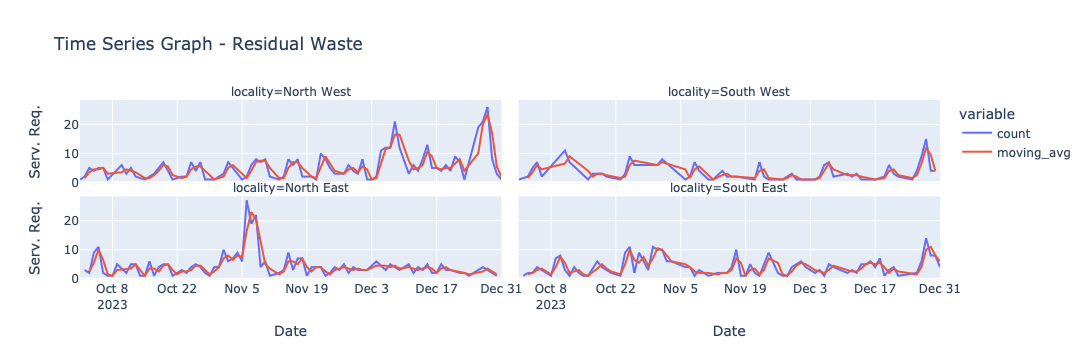

In [55]:
# @title
import pandas as pd
import plotly.express as px

# Assuming 'date' is the column representing the time series
gdf['service_request_recd'] = pd.to_datetime(gdf['service_request_recd'])

# Filter the data for 'Blue Box' service requests
residual_data = gdf[gdf['refuse_service'] == "Residual"]

# Group by date and locality and count the number of service requests for each date and locality
grouped_data = residual_data.groupby(['service_request_recd', 'locality']).size().reset_index(name='count')

# Compute a 7-day moving average
#grouped_data['moving_avg'] = grouped_data.groupby('locality')['count'].rolling(window=7).mean().reset_index(level=0, drop=True)

# Compute a moving average with a window size of 2 fortnights (equivalent to 4 weeks)
grouped_data['moving_avg'] = grouped_data.groupby('locality')['count'].rolling(window=2).mean().reset_index(level=0, drop=True)


# Create time series graph
fig = px.line(grouped_data, x='service_request_recd', y=['count', 'moving_avg'],
              facet_col='locality', facet_col_wrap=2,
              title='Time Series Graph - Residual Waste',
              labels={'service_request_recd': 'Date', 'value': 'Serv. Req.'},
              line_shape='linear')

fig.show()

### **Residual waste service requests by locality**

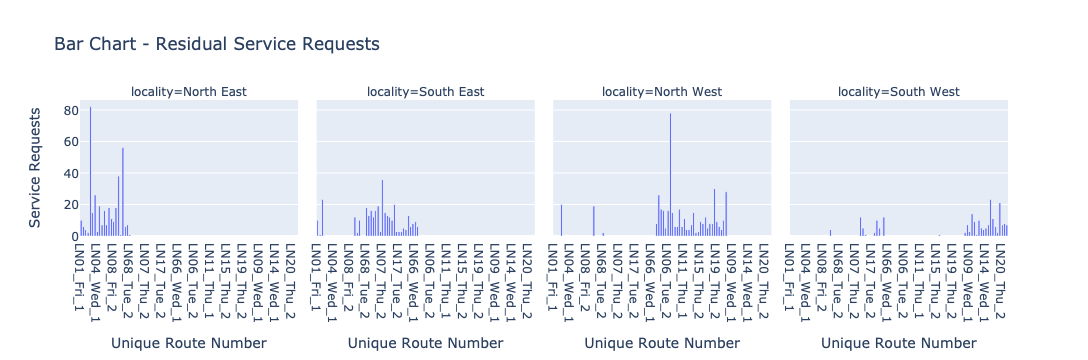

In [57]:
# @title
import pandas as pd
import plotly.express as px

# Assuming 'date' is the column representing the time series
gdf['service_request_recd'] = pd.to_datetime(gdf['service_request_recd'])

# Filter the data for the desired service requests
residual_data = gdf[gdf['refuse_service'] == "Residual"]

# Group by date and locality and count the number of service requests for each date and locality
grouped_data =residual_data.groupby(['unique_route_number', 'locality']).size().reset_index(name='count')

# Create bar chart
fig = px.bar(grouped_data, x='unique_route_number', y='count',
             facet_col='locality', facet_col_wrap=4,  # 2x2 grid
             title='Bar Chart - Residual Service Requests',
             labels={'unique_route_number': 'Unique Route Number', 'count': 'Service Requests'},  # Updated labels
             )

fig.show()

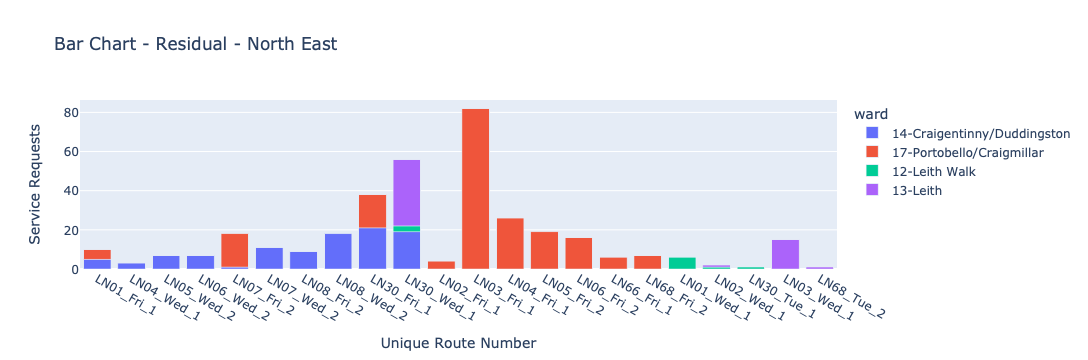

In [58]:
# @title
import pandas as pd
import plotly.express as px

# Assuming 'date' is the column representing the time series
gdf['service_request_recd'] = pd.to_datetime(gdf['service_request_recd'])

# Filter the data for the desired service requests
residual_data = gdf[(gdf['refuse_service'] == "Residual") & (gdf['locality'] == "North East") ]

# Group by date and locality and count the number of service requests for each date and locality
grouped_data = residual_data.groupby(['unique_route_number', 'ward']).size().reset_index(name='count')

# Create bar chart
fig = px.bar(grouped_data, x='unique_route_number', y='count', color='ward',
             #facet_col='locality', facet_col_wrap=4,  # 2x2 grid
             title='Bar Chart - Residual - North East',
             labels={'unique_route_number': 'Unique Route Number', 'count': 'Service Requests'},  # Updated labels
             )

fig.show()

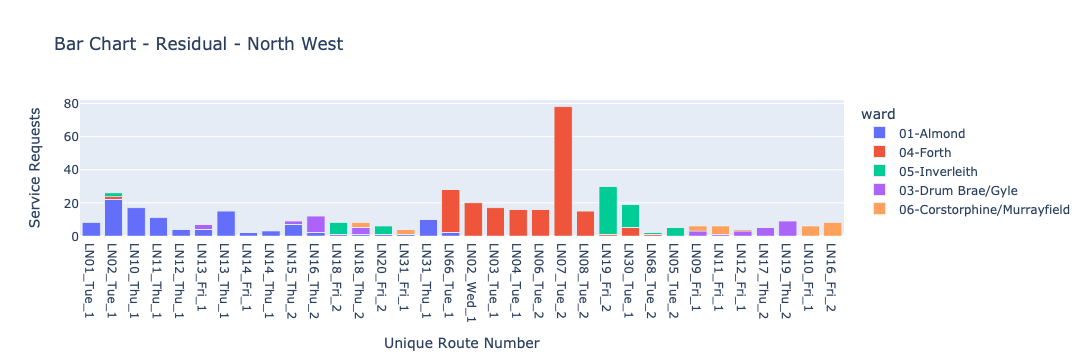

In [59]:
# @title
import pandas as pd
import plotly.express as px

# Assuming 'date' is the column representing the time series
gdf['service_request_recd'] = pd.to_datetime(gdf['service_request_recd'])

# Filter the data for the desired service requests
residual_data = gdf[(gdf['refuse_service'] == "Residual") & (gdf['locality'] == "North West")]

# Group by unique_route_number and locality and count the number of service requests for each unique_route_number and locality
grouped_data = residual_data.groupby(['unique_route_number', 'ward']).size().reset_index(name='count')

# Create bar chart
fig = px.bar(grouped_data, x='unique_route_number', y='count', color='ward',
             title='Bar Chart - Residual - North West',
             labels={'unique_route_number': 'Unique Route Number', 'count': 'Service Requests'},  # Updated labels
             )

fig.show()
